In [12]:
import sqlite3
import pandas as pd

import json
conn = sqlite3.connect('chat_history.db')

tables = conn.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
print("Tablolar:", tables)


df = pd.read_sql_query("SELECT * FROM chat_histories", conn)


conn.close()



import json
import base64
from PIL import Image
from io import BytesIO
def process_chat_history(id):
    data=df[df['id']==id]
    chat_data=eval(data.messages.iloc[0])
    messages=""
    images=[]
    for message in chat_data:
        if 'image' in message:

            base64_image = message['image'].split(",")[1]
            image_data = base64.b64decode(base64_image)
            

            image = Image.open(BytesIO(image_data))
            images.append(image)
        messages+=f"{message['type']}: {message['content']}"

return messages,images


Tablolar: [('chat_histories',)]


,id,title,messages,messages_hash,timestamp
0,1,chat-3ccf8689,"[{""type"": ""user"", ""content"": ""\u00e7\u00f6z"", ...",df65c01242ce1b5ac8fec96adac9fc5869548a69591010...,2024-10-27 19:43:39
1,2,chat-5f4fd574,"[{""type"": ""user"", ""content"": ""\u00e7\u00f6z ub...",fc05760d2b4b4fc360579294278dfccb4310c064f7c0cc...,2024-10-27 19:56:00
2,3,chat-7ca09eac,"[{""type"": ""user"", ""content"": ""aa"", ""image"": ""d...",8e9d34670684b708556480b434cf7595b3cfd89f5c8bde...,2024-10-27 19:57:39


'[{"type": "user", "content": "\\u00e7\\u00f6z", "image": "", "timestamp": "2024-10-27T19:43:23.662Z"}, {"type": "assistant", "content": "Here\'s how to solve the equation:\\n\\n1. **Subtract 1 from both sides:** \\n   2x + 1 - 1 = 10 - 1\\n   This simplifies to: 2x = 9\\n\\n2. **Divide both sides by 2:**\\n   2x / 2 = 9 / 2\\n   This gives you: x = 4.5\\n\\n**Therefore, x = 4.5** \\n", "timestamp": "2024-10-27T19:43:23.680Z"}]'
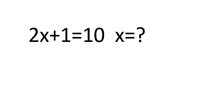

In [5]:
df.messages.iloc[0]

In [23]:
process_chat_history(eval(df.messages.iloc[0]))

user: çöz
assistant: Here's how to solve the equation:

1. **Subtract 1 from both sides:** 
   2x + 1 - 1 = 10 - 1
   This simplifies to: 2x = 9

2. **Divide both sides by 2:**
   2x / 2 = 9 / 2
   This gives you: x = 4.5

**Therefore, x = 4.5** 



'"[{\\"type\\": \\"user\\", \\"content\\": \\"\\\\u00e7\\\\u00f6z\\", \\"image\\": \\"\\", \\"timestamp\\": \\"2024-10-27T19:43:23.662Z\\"}, {\\"type\\": \\"assistant\\", \\"content\\": \\"Here\'s how to solve the equation:\\\\n\\\\n1. **Subtract 1 from both sides:** \\\\n   2x + 1 - 1 = 10 - 1\\\\n   This simplifies to: 2x = 9\\\\n\\\\n2. **Divide both sides by 2:**\\\\n   2x / 2 = 9 / 2\\\\n   This gives you: x = 4.5\\\\n\\\\n**Therefore, x = 4.5** \\\\n\\", \\"timestamp\\": \\"2024-10-27T19:43:23.680Z\\"}]"'
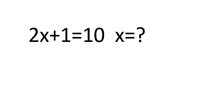

In [18]:
json.loads(json.dumps(df.messages.iloc[0]))

[{'type': 'user',
  'content': 'çöz',
  'image': '',
  'timestamp': '2024-10-27T19:43:23.662Z'},
 {'type': 'assistant',
  'content': "Here's how to solve the equation:\n\n1. **Subtract 1 from both sides:** \n   2x + 1 - 1 = 10 - 1\n   This simplifies to: 2x = 9\n\n2. **Divide both sides by 2:**\n   2x / 2 = 9 / 2\n   This gives you: x = 4.5\n\n**Therefore, x = 4.5** \n",
  'timestamp': '2024-10-27T19:43:23.680Z'}]
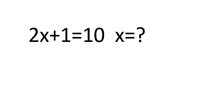

In [20]:
eval(df.messages.iloc[0])

In [26]:
import sqlite3
import json
import base64
from PIL import Image
from io import BytesIO
from typing import Tuple, List, Dict
from pathlib import Path
from contextlib import contextmanager


class ChatDatabase:
    
    def __init__(self, db_path: str = 'chat_history.db'):
        self.db_path = Path(db_path)
    
    @contextmanager
    def connect(self):
        """Veritabanı bağlantısı için context manager."""
        conn = None
        try:
            conn = sqlite3.connect(self.db_path)
            yield conn
        finally:
            if conn:
                conn.close()
    
    def get_tables(self) -> List[str]:
        with self.connect() as conn:
            cursor = conn.cursor()
            cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
            return [table[0] for table in cursor.fetchall()]

    def get_chat_history(self, chat_id: int) -> Dict:
        with self.connect() as conn:
            cursor = conn.cursor()
            cursor.execute(
                "SELECT messages FROM chat_histories WHERE id = ?", 
                (chat_id,)
            )
            result = cursor.fetchone()
            
            if not result:
                raise ValueError(f"Chat ID {chat_id} bulunamadı")
                
            return json.loads(result[0])

class MessageProcessor:
    
    @staticmethod
    def decode_image(base64_str: str) -> Image.Image:
        try:
            if ',' in base64_str:
                base64_str = base64_str.split(',')[1]
            
            image_data = base64.b64decode(base64_str)
            return Image.open(BytesIO(image_data))
        except Exception as e:
            print(f"Görüntü decode hatası: {e}")
            raise

    def process_messages(self, messages: List[Dict]) -> Tuple[str, List[Image.Image]]:
        text_messages = []
        images = []
        
        for message in messages:
            text_messages.append(f"{message['type']}: {message['content']}")
            
            if 'image' in message and message['image']:
                try:
                    image = self.decode_image(message['image'])
                    images.append(image)
                except Exception as e:
                    print(f"Görüntü işleme hatası: {e}")
        
        return '\n'.join(text_messages), images

def main():
    """Ana program fonksiyonu."""
    try:
        db = ChatDatabase()
        processor = MessageProcessor()
        
        tables = db.get_tables()
        
        chat_id = 1
        chat_messages = db.get_chat_history(chat_id)
        
        messages, images = processor.process_messages(chat_messages)
        
            
    except Exception as e:
        print(f"Program hatası: {e}")
        raise

if __name__ == "__main__":
    main()

ModuleNotFoundError: No module named 'manim_voiceover'

In [1]:
with open("manicode.py", "r", encoding="utf-8") as f:
    manim_code=f.read()

In [2]:
manim_code="""
class Solution():
    def construct(self):
        pass
"""

In [3]:
exec(manim_code)

In [4]:
Solution()

In [ ]:
from manim import *

class CreateCircle(Scene):
    def construct(self):
        circle = Circle()  
        circle.set_fill(PINK, opacity=0.5)  
        self.play(Create(circle))  


config.media_dir =  "backend"
s = CreateCircle()
s.render()

In [3]:
import sqlite3
import pandas as pd

import json
conn = sqlite3.connect('chat_history.db')

tables = conn.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
print("Tablolar:", tables)


df = pd.read_sql_query("SELECT * FROM chat_histories", conn)


conn.close()


Tablolar: [('chat_histories',)]


In [ ]:
df.iloc[0].messages